In [2]:
import os

import pickle
import random
import numpy as np
import pandas as pd
from easydict import EasyDict as edict
from i1kmop1 import In1KMOPProblem, in1kmop

os.chdir('/home/wcx/gitProject/evoxbench/evoxbench_submit/c10mop8-9&i1k/i1kmop1')

Auto Configuration Succeed!, Using database /home/wcx/gitProject/evoxbench/database/database.
Auto Configuration Succeed!, Using database /home/wcx/gitProject/evoxbench/database/database.
['/home/wcx/gitProject/evoxbench/evoxbench_submit/pymoo050/', '/home/wcx/gitProject/evoxbench/evoxbench_submit/', '/sdb_new/gitProject/evoxbench/evoxbench_submit/c10mop8-9&i1k/i1kmop1', '/home/wcx/anaconda3/envs/evoxbench/lib/python38.zip', '/home/wcx/anaconda3/envs/evoxbench/lib/python3.8', '/home/wcx/anaconda3/envs/evoxbench/lib/python3.8/lib-dynload', '', '/home/wcx/.local/lib/python3.8/site-packages', '/home/wcx/anaconda3/envs/evoxbench/lib/python3.8/site-packages', '/home/wcx/gitProject/evoxbench/database/database', '/home/wcx/gitProject/evoxbench/database/database']


In [3]:
args = edict()
args.run = 2
args.seed = args.run
args.pid = 1

In [4]:
# set seed
random.seed(args.seed)
np.random.seed(args.seed)

In [5]:
benchmark = in1kmop(args.pid)
problem = In1KMOPProblem(benchmark, args.pid)

# Sample and divide the dataset

In [6]:
d = './'
obj_d = d + '1kl_train_data_3000_{:02d}.pkl'.format(args.run)
search_space = benchmark.search_space
evaluator = benchmark.evaluator
if not os.path.exists(obj_d):
    
    X = np.array([search_space._sample(phenotype=False) for _ in range(3000)])
    X = X[problem._get_fine_x(X)]
    
    archs = search_space.decode(X)
    y = evaluator.evaluate(archs, true_eval=True)
    pickle.dump((X, y), open(obj_d, 'wb')) 
    whole_X, whole_y = X.copy(), y.copy()
else:
    X, y = pickle.load(open(obj_d, 'rb'))
    whole_X, whole_y = X.copy(), y.copy()

In [7]:
X.shape

(3000, 25)

In [8]:
y

[OrderedDict([('err', 0.2619360289092265), ('params', 21225896)]),
 OrderedDict([('err', 0.21681469978703927), ('params', 25651288)]),
 OrderedDict([('err', 0.2308565924219813), ('params', 24168120)]),
 OrderedDict([('err', 0.2546964034557886), ('params', 25442080)]),
 OrderedDict([('err', 0.21028583206966378), ('params', 23821568)]),
 OrderedDict([('err', 0.21078906564254762), ('params', 26951160)]),
 OrderedDict([('err', 0.23303082935385366), ('params', 31206648)]),
 OrderedDict([('err', 0.23042742622037082), ('params', 12542384)]),
 OrderedDict([('err', 0.21159228207519676), ('params', 19275696)]),
 OrderedDict([('err', 0.2533703022104826), ('params', 14896584)]),
 OrderedDict([('err', 0.2745042392008957), ('params', 11998816)]),
 OrderedDict([('err', 0.20831592527332554), ('params', 26696112)]),
 OrderedDict([('err', 0.22271937739125258), ('params', 27543840)]),
 OrderedDict([('err', 0.20672522966852247), ('params', 23816912)]),
 OrderedDict([('err', 0.2351885005341493), ('params',

<AxesSubplot: ylabel='Count'>

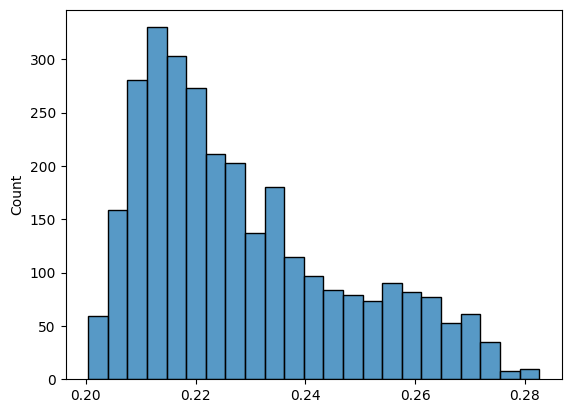

In [9]:
import seaborn as sns
sns.histplot([i['err'] for i in y])

In [10]:
X.shape

(3000, 25)

# Train the accuracy model

In [11]:
def aux_err(train_x, train_y):
    import numpy as np
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from catboost import CatBoostRegressor, Pool
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=args.seed)

    models, errs = [], []
    X, y = train_x, train_y
    for train_idx, test_idx in kfold.split(X, y):
        model = CatBoostRegressor(iterations=10000, learning_rate=0.1, depth=6, random_seed=args.seed,
                                loss_function='RMSE', verbose=True, early_stopping_rounds=1000)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train, eval_set=Pool(X_test, y_test), use_best_model=True, verbose=500)
        
        y_pred = model.predict(X_test)
        models.append(model)
        
        err = mean_absolute_error(y_test, y_pred)
        errs.append(err)

    return models, errs

In [12]:
train_len = 2000
train_x, train_y = X[:train_len], y[:train_len]
test_x, test_y = X[train_len:], y[train_len:]
print('train data shape: ', train_x.shape, '\ntest data shape: ', test_x.shape)

trn_x = train_x
trn_y = np.array([i['err'] for i in train_y])
tst_x = test_x
tst_y = np.array([i['err'] for i in test_y])
err_models, mae_errs = aux_err(trn_x, trn_y)

train data shape:  (2000, 25) 
test data shape:  (1000, 25)
0:	learn: 0.0170352	test: 0.0168798	best: 0.0168798 (0)	total: 48.9ms	remaining: 8m 9s
500:	learn: 0.0001377	test: 0.0011882	best: 0.0011882 (498)	total: 489ms	remaining: 9.27s
1000:	learn: 0.0000294	test: 0.0011663	best: 0.0011662 (994)	total: 912ms	remaining: 8.2s
1500:	learn: 0.0000073	test: 0.0011643	best: 0.0011643 (1497)	total: 1.35s	remaining: 7.63s
2000:	learn: 0.0000020	test: 0.0011639	best: 0.0011639 (1997)	total: 1.78s	remaining: 7.13s
2500:	learn: 0.0000006	test: 0.0011639	best: 0.0011639 (2493)	total: 2.23s	remaining: 6.68s
3000:	learn: 0.0000002	test: 0.0011639	best: 0.0011639 (2961)	total: 2.67s	remaining: 6.24s
3500:	learn: 0.0000000	test: 0.0011638	best: 0.0011638 (3422)	total: 3.13s	remaining: 5.81s
4000:	learn: 0.0000000	test: 0.0011638	best: 0.0011638 (3999)	total: 3.55s	remaining: 5.33s
4500:	learn: 0.0000000	test: 0.0011638	best: 0.0011638 (4427)	total: 3.98s	remaining: 4.86s
5000:	learn: 0.0000000	test: 

In [13]:
mae_errs

[0.0008000581194968626,
 0.0007693737116276612,
 0.0007597436555864009,
 0.0007456221380863348,
 0.0007947368279627187]

In [14]:
import pickle
d = './'
pickle.dump(err_models, open(d + 'err_models_2000.pkl', 'wb'))

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
pred_y_list = []
for model in err_models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y)
pred_y = np.array(pred_y_list).mean(axis=0)
mse_err = mean_squared_error(tst_y, pred_y)
mae_err = mean_absolute_error(tst_y, pred_y)
print('mse_err: ', mse_err, '\nmae_err: ', mae_err)

mse_err:  1.2336549534940408e-06 
mae_err:  0.0007281091293022903


(0.0, 35.0)

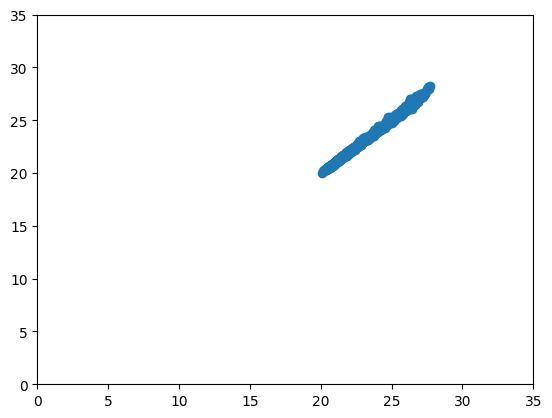

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

comp = pd.DataFrame({'pred': pred_y, 'true': tst_y})
plt.scatter(comp['pred']*100, comp['true']*100)
plt.xlim(0, 35)
plt.ylim(0, 35)

In [17]:
def get_pred_err(X):
    pred_y_list = []
    for model in err_models:
        pred_y = model.predict(X)
        pred_y_list.append(pred_y)
    return np.array(pred_y_list).mean(axis=0)

In [18]:
get_pred_err(test_x[:10])

array([0.26948836, 0.21149583, 0.21414203, 0.23610169, 0.21313321,
       0.24528062, 0.20951302, 0.24928278, 0.23420331, 0.27371191])

# Get the params and flops

In fact, in neural architecture search problems, the number of parameters and flops is not an expensive task and can be obtained directly.

In [31]:
# ignore this cell
## Nevertheless, the model is better because the \
## number of model parameters is evenly distributed than the accuracy

# def aux_flops(train_x, train_y):
def aux_params(train_x, train_y):
    import numpy as np
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from catboost import CatBoostRegressor, Pool
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=args.seed)

    models, errs = [], []
    X, y = train_x, train_y
    for train_idx, test_idx in kfold.split(X, y):
        model = CatBoostRegressor(iterations=10000, learning_rate=0.1, depth=6, random_seed=args.seed,
                                loss_function='RMSE', verbose=True, early_stopping_rounds=1000)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train, eval_set=Pool(X_test, y_test), use_best_model=True, verbose=500)
        
        # evaluate the model
        y_pred = model.predict(X_test)
        models.append(model)
        
        err = mean_squared_error(y_test, y_pred)
        errs.append(err)

    return models, errs

In [19]:
benchmark.evaluate([X[0]])

array([[2.20978325e-01, 2.12258960e+07]])

In [20]:
def get_pred_params_direct(X):
    return benchmark.evaluate(X)[:, 1]

In [21]:
def get_pred_flops_direct(X):
    return benchmark.evaluate(X)[:, 2]

In [23]:
real_param = get_pred_params_direct(test_x[:10])
# real_flops = get_pred_flops_direct(test_x[:10])
real_param

array([12577904., 22877904., 20381008., 31046768., 18413464., 21975960.,
       22055840., 15155544., 29729240., 13465064.])